# Model selection and evaluation

__Notes__

1. Create set of rules for what reviews to accept or throw out
    1. Min or max number of words
    1. Include URLs or not
    1. Emojis
    1. Eliminate stop words
    
1. Model selection
    1. CNN for usefulness
    1. Sample from useful reviews only
    1. Setup T5 transfering learning model to generate "justification" text

- LSTM is good
    - You can add in an attention layer because it can look backwards and learn what words were more important than others
- CNN is good for sentence classification 
    - With a fully connected Dense layer it is not good at generalizing
- BERT is good because of its self-attention mechanism where every word looks at every other layer
    - Use the CLS token as the only thing you feed into the output layer that is going to make the prediction on the classification

## 0.0 Notebook setup

### X.X Colab Setup

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
! mkdir data

In [48]:
! cp "/content/gdrive/My Drive/nlp-book-reviews/data/electronics.csv" ./data/

In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12627603964853574905
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11566186152829940842
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [6]:
!pip install --quiet transformers

     |████████████████████████████████| 3.8 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 39.6 MB/s 
     |████████████████████████████████| 6.5 MB 35.9 MB/s 
     |████████████████████████████████| 67 kB 5.5 MB/s 
     |████████████████████████████████| 895 kB 41.8 MB/s 


### X.X Local setup

In [7]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

In [8]:
# Statistics
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, norm, skew, kurtosis

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_curve, auc, accuracy_score

# Model building
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, Dense, Flatten, LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# BERT-specific
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

In [49]:
# Local
# data = '../data/electronics.csv'

# Colab
data = './data/electronics.csv'

review_samples = pd.read_csv(data)

## X.X Usefulness language modeling

In [10]:
review_samples['useful'].value_counts()

1    5994
0    5182
Name: useful, dtype: int64

In [11]:
reviews = review_samples['review_processed'].fillna('no review')
labels = review_samples['useful'].astype(int)
sentiment = ['Not Useful', 'Useful']

### X.X Baseline - Naive Bayes

In [12]:
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)

X_train_tfidf = tf_idf.fit_transform(X_train)
X_dev_tfidf = tf_idf.transform(X_dev)
X_test_tfidf = tf_idf.transform(X_test)

In [13]:
# Build model
nb_model = MultinomialNB(alpha=1.8)

# Fit model
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.8)

In [14]:
# Evaluate model on dev data
train_acc = nb_model.score(X_train_tfidf, y_train)
dev_acc = nb_model.score(X_dev_tfidf, y_dev)
test_acc = nb_model.score(X_test_tfidf, y_test)

print(train_acc, dev_acc, test_acc)

0.874869500372856 0.5458612975391499 0.554561717352415


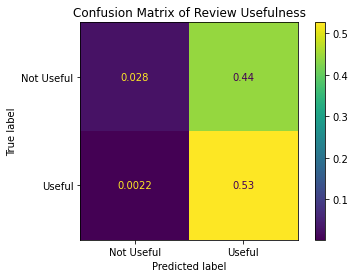

In [15]:
# Evaluate model on test data and plot confusion matrix
y_true = y_test
y_pred = nb_model.predict(X_test_tfidf)

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

AUC: 0.5273


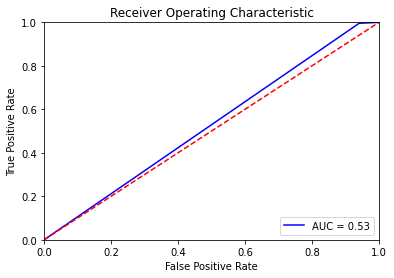

In [16]:
fpr, tpr, threshold = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

# Plot ROC AUC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### X.X O'Reilly Deep Learning Example

In [60]:
# Set tokenization parameters
num_words = None
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Tokenize review text
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

# Additional tokenization parameters
max_words = len(tokenizer.word_index)
max_len = max([len(x) for x in sequences])
# max_words = 5000
# max_len = 125

# Pad review text tokens
reviews_tokens = pad_sequences(sequences, padding=pad_type, truncating=trunc_type, maxlen=max_len)

# Create usefulness target variable
labels = review_samples['useful']
# labels = tf.keras.utils.to_categorical(labels, num_classes=2, dtype="float32")
labels = np.asarray(labels).astype("float32")


In [61]:
review_samples['review_processed'].iloc[0]

"it does not copy cd-r s to usb as advertised. my cd's were recorded on a sony machine and properly finalized. they copy on other machines. it repeatedly shows copy protected wait. none of my cd-r s are copy protected. i do want a machine that will copy my cd-r collection to usb."

In [62]:
(max_words, max_len)

(24063, 4074)

In [94]:
# Set model hyperparamters
epochs = 10
batch_size = 32
dropout_rate = 0.7
num_classes = len(np.unique(labels, axis=0))
opt = tf.keras.optimizers.Adam(learning_rate=0.001,
                               epsilon=0.00000001,
                               clipnorm=1.0
                              )
loss_func = 'binary_crossentropy'
metrics = ['accuracy']

In [64]:
# Split data into train, dev, and test sets
X_train, X_test, y_train, y_test = train_test_split(reviews_tokens, labels, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [65]:
y_test.shape

(2236,)

In [68]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(max_len,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss=loss,
              metrics=metrics)
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 16)                65200     
                                                                 
 dense_15 (Dense)            (None, 16)                272       
                                                                 
 dense_16 (Dense)            (None, 1)                 17        
                                                                 
Total params: 65,489
Trainable params: 65,489
Non-trainable params: 0
_________________________________________________________________


In [69]:
model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=4, batch_size=512)
model.evaluate(X_test, y_test)

Epoch 1/4
14/14 [==============================] - 2s 43ms/step - loss: 30.3917 - accuracy: 0.5445 - val_loss: 22.1155 - val_accuracy: 0.4971
Epoch 2/4
14/14 [==============================] - 0s 21ms/step - loss: 10.2396 - accuracy: 0.5670 - val_loss: 10.1866 - val_accuracy: 0.5025
Epoch 3/4
14/14 [==============================] - 0s 18ms/step - loss: 4.8399 - accuracy: 0.5460 - val_loss: 5.8043 - val_accuracy: 0.4743
Epoch 4/4
70/70 [==============================] - 0s 6ms/step - loss: 3.1015 - accuracy: 0.5237


[3.1015477180480957, 0.5237030386924744]

### X.X Bi-directional LSTM

In [70]:
labels = review_samples['useful']
labels = tf.keras.utils.to_categorical(labels, num_classes=2, dtype="float32")

In [71]:
# Split data into train, dev, and test sets
X_train, X_test, y_train, y_test = train_test_split(reviews_tokens, labels, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [72]:
# Build model
lstm_model = Sequential()
lstm_model.add(Embedding(max_words, 40, input_length=max_len))
lstm_model.add(Bidirectional(LSTM(20, dropout=dropout_rate)))
lstm_model.add(Dense(2, activation='sigmoid'))
lstm_model.compile(optimizer=opt, loss=loss_func, metrics=metrics)
lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 4074, 40)          962520    
                                                                 
 bidirectional_2 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_17 (Dense)            (None, 2)                 82        
                                                                 
Total params: 972,362
Trainable params: 972,362
Non-trainable params: 0
_________________________________________________________________


In [73]:
# Fit model
lstm_model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs, batch_size=512, verbose=2)

Epoch 1/10
14/14 - 20s - loss: 0.6905 - accuracy: 0.5336 - val_loss: 0.6883 - val_accuracy: 0.5306 - 20s/epoch - 1s/step
Epoch 2/10
14/14 - 15s - loss: 0.6798 - accuracy: 0.5682 - val_loss: 0.6731 - val_accuracy: 0.6036 - 15s/epoch - 1s/step
Epoch 3/10
14/14 - 15s - loss: 0.6570 - accuracy: 0.6260 - val_loss: 0.6633 - val_accuracy: 0.6134 - 15s/epoch - 1s/step
Epoch 4/10
14/14 - 15s - loss: 0.6402 - accuracy: 0.6483 - val_loss: 0.6637 - val_accuracy: 0.6085 - 15s/epoch - 1s/step
Epoch 5/10
14/14 - 15s - loss: 0.6293 - accuracy: 0.6504 - val_loss: 0.6625 - val_accuracy: 0.6152 - 15s/epoch - 1s/step
Epoch 6/10
14/14 - 15s - loss: 0.6151 - accuracy: 0.6628 - val_loss: 0.6563 - val_accuracy: 0.6130 - 15s/epoch - 1s/step
Epoch 7/10
14/14 - 15s - loss: 0.5866 - accuracy: 0.7043 - val_loss: 0.6553 - val_accuracy: 0.6251 - 15s/epoch - 1s/step
Epoch 8/10
14/14 - 15s - loss: 0.5490 - accuracy: 0.7426 - val_loss: 0.6638 - val_accuracy: 0.6183 - 15s/epoch - 1s/step
Epoch 9/10
14/14 - 15s - loss: 0

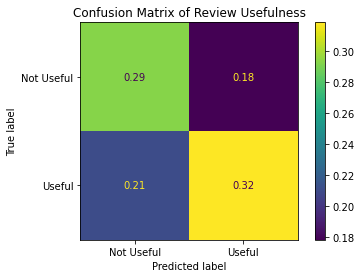

In [85]:
# Plot confusion matrix
y_true = y_test.argmax(axis=1)
y_pred = np.argmax(lstm_model.predict(X_test), axis=1)

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [86]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.62      0.60      1053
           1       0.64      0.60      0.62      1183

    accuracy                           0.61      2236
   macro avg       0.61      0.61      0.61      2236
weighted avg       0.61      0.61      0.61      2236



In [107]:
# Evaluate model
loss, acc = lstm_model.evaluate(X_test, y_test, verbose=1)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nLoss: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(acc, loss, precision, recall, f1))

ValueError: ignored

In [88]:
example0 = "Golf tips magazine is one of the most aptly titled magazines available today. \
            It is chock full of heavily-illustrated exercises and other tips for serious golfers to improve their games.\
            \nThere are a number of golf magazines on the newstand today. Most of them rely on a lifestyle format relying \
            more heavily on lifestyle-type stories about today's hot golfers and the courses they play. Most of them include \
            a brief game tip or two but seem aimed at the casual duffer.\nGolf Tips, on the other hand, features almost nothing \
            but heavily illustrated tips on improving one's swing, eliminating mistakes and putting better. It also is heavily \
            loaded with features on the latest equipment technology. Each issue also seems to feature an article on the technical \
            aspects of a selected major golf course. The articles are written with terminology that serious golfers will understand \
            but that may confuse the weekend player. Judging by the amount of advertising in its early issues, this magazine also \
            appears to be financially healthy.\nIf a reader wants to read about the PGA Tour's superstars, this magazine is not for \
            him/her. But if s/he plans to be one of those superstars, Golf Tips is a good match."

example1 = "The information is interesting and fun, the writing is superb, and the writers and editors have a great sense of humor. \
            I just wish it came out more often!"

example2 = "this data science article is the best ever"

example3 = "i really loved how the technician helped me with the issue that i had"

example4 = "useless comment"

examples = [example0, example1, example2, example3, example4]

In [89]:
def test_examples(model, examples):
    for idx, example in enumerate(examples):
        sequence = tokenizer.texts_to_sequences([example])
        test = pad_sequences(sequence, maxlen=max_len)
        prediction = sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]
        print(idx, ":", prediction)
    
test_examples(lstm_model, examples)

0 : Not Useful
1 : Not Useful
2 : Not Useful
3 : Not Useful
4 : Not Useful


### X.X Convolutional neural network

In [90]:
# # Change data type from float to int
y_train = np.array([list(i).index(max(i)) for i in y_train])
y_dev = np.array([list(i).index(max(i)) for i in y_dev])
y_test = np.array([list(i).index(max(i)) for i in y_test])

# labels = review_samples['useful'].astype(int)
# X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=0)
# X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [91]:
y_test.shape

(2236,)

In [95]:
# Build model
cnn_model = Sequential()
cnn_model.add(Embedding(max_words, 32, input_length=max_len))
cnn_model.add(Conv1D(32, 3, padding='same', activation='relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(250, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(optimizer=opt, loss=loss_func, metrics=metrics)
cnn_model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 4074, 32)          770016    
                                                                 
 conv1d_1 (Conv1D)           (None, 4074, 32)          3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2037, 32)         0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 65184)             0         
                                                                 
 dense_20 (Dense)            (None, 250)               16296250  
                                                                 
 dense_21 (Dense)            (None, 1)                 251       
                                                      

In [96]:
# Fit model
cnn_model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs, batch_size=512, verbose=2)

Epoch 1/10
14/14 - 13s - loss: 0.8157 - accuracy: 0.5069 - val_loss: 0.6851 - val_accuracy: 0.5306 - 13s/epoch - 903ms/step
Epoch 2/10
14/14 - 4s - loss: 0.6673 - accuracy: 0.5684 - val_loss: 0.6831 - val_accuracy: 0.5852 - 4s/epoch - 254ms/step
Epoch 3/10
14/14 - 4s - loss: 0.6522 - accuracy: 0.6179 - val_loss: 0.6799 - val_accuracy: 0.5911 - 4s/epoch - 255ms/step
Epoch 4/10
14/14 - 3s - loss: 0.6301 - accuracy: 0.6427 - val_loss: 0.6807 - val_accuracy: 0.5969 - 3s/epoch - 248ms/step
Epoch 5/10
14/14 - 4s - loss: 0.5949 - accuracy: 0.6628 - val_loss: 0.6936 - val_accuracy: 0.6063 - 4s/epoch - 251ms/step
Epoch 6/10
14/14 - 3s - loss: 0.5396 - accuracy: 0.7108 - val_loss: 0.7039 - val_accuracy: 0.6116 - 3s/epoch - 249ms/step
Epoch 7/10
14/14 - 3s - loss: 0.4599 - accuracy: 0.8073 - val_loss: 0.7762 - val_accuracy: 0.6085 - 3s/epoch - 249ms/step
Epoch 8/10
14/14 - 3s - loss: 0.3595 - accuracy: 0.8568 - val_loss: 0.8902 - val_accuracy: 0.6000 - 3s/epoch - 245ms/step
Epoch 9/10
14/14 - 3s 

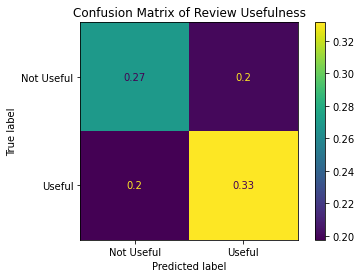

In [108]:
# Plot confusion matrix
y_true = y_test
y_pred = (cnn_model.predict(X_test) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [109]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.57      0.58      1053
           1       0.62      0.63      0.62      1183

    accuracy                           0.60      2236
   macro avg       0.60      0.60      0.60      2236
weighted avg       0.60      0.60      0.60      2236



In [111]:
# Evaluate model
loss, acc = cnn_model.evaluate(X_test, y_test, verbose=1)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nLoss: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(acc, loss, precision, recall, f1))

70/70 [==============================] - 1s 11ms/step - loss: 1.1708 - accuracy: 0.6015
Model performance metrics on test data
Accuracy: 0.6015
Loss: 1.1708
Precision: 0.6014
Recall: 0.6015
F1-score: 0.6014


In [112]:
test_examples(cnn_model, examples)

0 : Not Useful
1 : Not Useful
2 : Not Useful
3 : Not Useful
4 : Not Useful


### X.X BERT

[TF BERT Tutorial](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)

In [113]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 5.2 MB/s 
     |████████████████████████████████| 462 kB 47.5 MB/s 


In [114]:
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 5.5 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 352 kB 30.6 MB/s 
     |████████████████████████████████| 90 kB 7.4 MB/s 
     |████████████████████████████████| 1.1 MB 9.8 MB/s 
     |████████████████████████████████| 237 kB 35.5 MB/s 
     |████████████████████████████████| 99 kB 6.9 MB/s 
     |████████████████████████████████| 47.8 MB 42 kB/s 
     |████████████████████████████████| 1.2 MB 33.5 MB/s 


In [115]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

tf.get_logger().setLevel('ERROR')

In [116]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [117]:
reviews = review_samples['review_processed'].fillna('no review')
labels = review_samples['useful'].astype(int)

X, y = reviews, labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [118]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [119]:
text_test = ['this is such an amazing movie!']
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.90388924]], shape=(1, 1), dtype=float32)


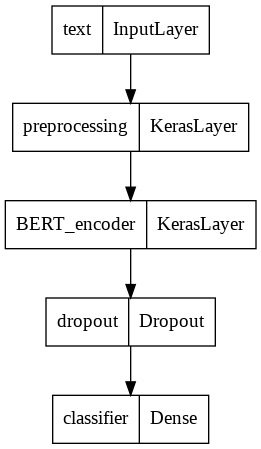

In [120]:
tf.keras.utils.plot_model(classifier_model)

In [121]:
loss_func = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [122]:
epochs = 5
steps_per_epoch = len(X_train)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [123]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss_func,
                         metrics=metrics)

In [124]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=X_train,
                               y=y_train,
                               validation_data=(X_dev, y_dev),
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
210/210 [==============================] - 114s 506ms/step - loss: 0.7767 - binary_accuracy: 0.5053 - val_loss: 0.6883 - val_binary_accuracy: 0.5414
Epoch 2/5
210/210 [==============================] - 105s 501ms/step - loss: 0.6743 - binary_accuracy: 0.5670 - val_loss: 0.6697 - val_binary_accuracy: 0.5848
Epoch 3/5
210/210 [==============================] - 104s 496ms/step - loss: 0.6548 - binary_accuracy: 0.5869 - val_loss: 0.6713 - val_binary_accuracy: 0.5320
Epoch 4/5
210/210 [==============================] - 104s 497ms/step - loss: 0.6443 - binary_accuracy: 0.5934 - val_loss: 0.6595 - val_binary_accuracy: 0.5512
Epoch 5/5
210/210 [==============================] - 104s 494ms/step - loss: 0.6251 - binary_accuracy: 0.6273 - val_loss: 0.6708 - val_binary_accuracy: 0.5463


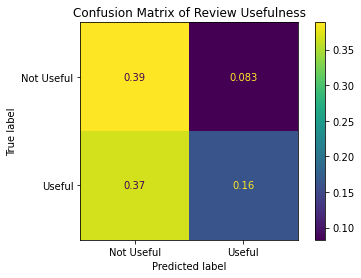

In [125]:
# Plot confusion matrix
y_true = y_test
y_pred = (classifier_model.predict(X_test) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [126]:
# Evaluate model
loss, accuracy = classifier_model.evaluate(X_test, y_test)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nLoss: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(acc, loss, precision, recall, f1))

70/70 [==============================] - 14s 203ms/step - loss: 0.6510 - binary_accuracy: 0.5505
Model performance metrics on test data
Accuracy: 0.6015
Loss: 0.6510
Precision: 0.5926
Recall: 0.5505
F1-score: 0.5202


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


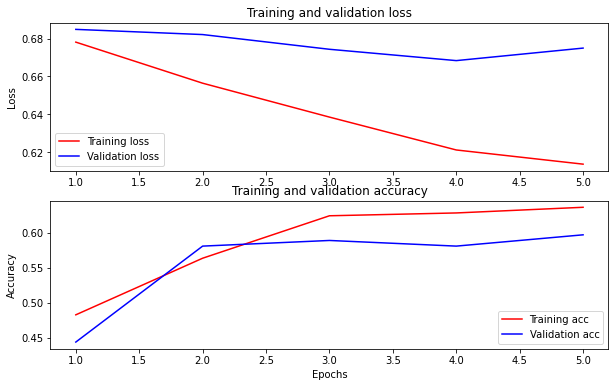

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## X.X Explanation transfer learning

In [ ]:
# from transformers.models.t5 import T5Model
from transformers import TFT5Model

In [ ]:
model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "max_seq_length": 128,
    "train_batch_size": 8,
    "num_train_epochs": 1,
    "save_eval_checkpoints": True,
    "save_steps": -1,
    "use_multiprocessing": False,
    "evaluate_during_training": True,
    "evaluate_during_training_steps": 15000,
    "evaluate_during_training_verbose": True,
    "fp16": False,

    "wandb_project": "Question Generation with T5",
}

model = TFT5Model.from_pretrained("t5-small")

### X.X Pre-trained sentiment span extraction model

https://huggingface.co/mrm8488/t5-base-finetuned-span-sentiment-extraction

In [ ]:
example = review_samples.iloc[2]['reviewText']

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-span-sentiment-extraction")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-span-sentiment-extraction")

def get_sentiment_span(text):
    input_ids = tokenizer.encode(text, return_tensors="pt", add_special_tokens=True)  # Batch size 1

    generated_ids = model.generate(input_ids=input_ids, num_beams=1, max_length=80).squeeze()

    predicted_span = tokenizer.decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

    return predicted_span
  
get_sentiment_span("question: negative context: My bike was put on hold...should have known that.... argh total bummer")

# output: 'argh total bummer'

get_sentiment_span("question: positive context: On the monday, so i wont be able to be with you! i love you")

# output: 'i love you'

In [ ]:
get_sentiment_span("question: negative context: {}".format(example))

In [ ]:
review_samples.iloc[2]['reviewText']